<a href="https://colab.research.google.com/github/brenosyperrek/ufsc_dc_exercicios/blob/main/3_Data_Visualization_Resolvido.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seção 3: Visualização de Dados

O cérebro humano é excelente em achar padrões nas representações visuais de dados; então, nesta seção, nós vamos aprender como visualizar dados usando o pandas, junto com as bibliotecas Matplotlib e Seaborn, para conseguir recursos adicionais. Vamos criar uma variedade de visualizações que vão nos ajudar a entender melhor nossos dados

## Plotagem com o Pandas

Podemos criar uma variedade de representações usando o método `plot()`. Nesta seção, vamos fazer um breve tour desta funcionalidade, que debaixo dos panos usa o Matplotlib.

Mais uma vez, vamos estar trabalhando com os dados do fluxo de viajantes TSA que vimos na seção anterior:

In [ ]:
import pandas as pd

url = 'https://raw.githubusercontent.com/stefmolin/pandas-workshop/main/data/tsa_melted_holiday_travel.csv'

tsa_melted_holiday_travel = pd.read_csv(
    url, 
    parse_dates=True, index_col='date'
)
tsa_melted_holiday_travel.head()

,year,travelers,holiday
date,,,
2019-01-01,2019,2126398.0,New Year's Day
2019-01-02,2019,2345103.0,New Year's Day
2019-01-03,2019,2202111.0,NaN
2019-01-04,2019,2150571.0,NaN
2019-01-05,2019,1975947.0,NaN


Para incorporar gráficos em formato SVG no notebook, vamos também chamar as mágicas `%config` e `%matplotlib inline`:

In [ ]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

*Dica: Leia mais sobre mágicas [aqui](https://ipython.readthedocs.io/en/stable/interactive/magics.html).*

### Plotagem de linha

O método `plot()` vai gerar plotagens de linha para todas as colunas numéricas, por padrão:


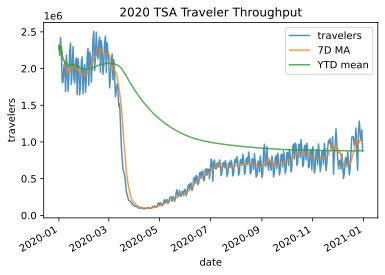

In [ ]:
tsa_melted_holiday_travel.drop(columns='year').loc['2020'].assign(
    **{
        '7D MA': lambda x: x.travelers.rolling('7D').mean(),
        'YTD mean': lambda x: x.travelers.expanding().mean()
      }
).plot(title='2020 TSA Traveler Throughput', ylabel='travelers', alpha=0.8)

O método `plot()` returna um objeto `Axes`, que pode ser modificado depois (por exemplo, para adicionar linhas de referência, anotações, labels, etc.). Vamos passar por um exemplo.

### Plotagem de barras

Para o nosso próximo exemplo, vamos fazer a plotagem de barras verticais para comparar o fluxo de passageiros TSA mensal, durante os anos. Vamos começar criando uma tabela de pivôs com a informação que precisamos:


In [ ]:
plot_data = tsa_melted_holiday_travel['2019':'2021-04']\
    .assign(month=lambda x: x.index.month)\
    .pivot_table(index='month', columns='year', values='travelers', aggfunc='sum')
plot_data.head()

year,2019,2020,2021
month,,,
1,59405722.0,61930286.0,23598230.0
2,57345684.0,60428859.0,24446345.0
3,72530252.0,32995003.0,38050060.0
4,70518994.0,3322548.0,41826159.0
5,74617773.0,7244733.0,NaN


Pandas oferece outros tipos de plotagem, através do parâmetro `kind`, então nós especificamos `kind='bar'` quando chamamos o método `plot()`. Depois, nós formatamos a visualização usando o objeto `Axes` retornado pelo método `plot()`:


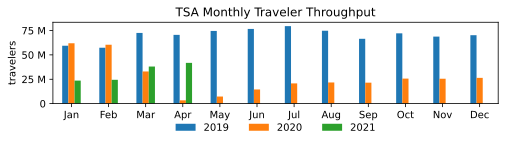

In [ ]:
import calendar
from matplotlib import ticker

ax = plot_data.plot(
    kind='bar', rot=0, xlabel='', ylabel='travelers',
    figsize=(8, 1.5), title='TSA Monthly Traveler Throughput'
)

# use month abbreviations for the ticks on the x-axis
ax.set_xticklabels(calendar.month_abbr[1:])

# show y-axis labels in millions instead of scientific notation
ax.yaxis.set_major_formatter(ticker.EngFormatter())

# customize the legend
ax.legend(title='', loc='center', bbox_to_anchor=(0.5, -0.3), ncol=3, frameon=False)

Algumas coisas para manter em mente:
- O módulo `ticker` do Matplotlib providencia funcionadade para customizar tanto os labels tick e localizações &ndash; Cheque a [documentação](https://matplotlib.org/stable/api/ticker_api.html) para conseguir mais informação.
- Pandas suporta barras horizontais e empilhadas também; [essa](https://medium.com/@stefaniemolin/how-to-pivot-and-plot-data-with-pandas-9450939fcf8) postagem de blog mostra como fazer barras horizontais empilhadas usando uma tabela de pivôs.
- O método `plot()` toma muitos [parâmetros](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html), muitos dos quais são passados para o Matplotlib; no entanto, algumas vezes nós precisamos de chamadas do Matplotlib diretas.


### Visualização de Distribuições

Vamos agora comparar a distribuição dos dados diários do fluxo de passageiros TSA ao longo dos anos. Vamos criar uma subplotagem para cada ano com um histograma e um kernel density estimate (KDE) para a distribuição. Pandas gerou os objetos `Figure` e `Axes` para ambos os exemplos até agora, mas nós podemos construir layouts exclusivos criando eles nós mesmos usando o Matplotlib com a função `plt.subplots()`. Primeiro, vamos precisar importar o módulo `pyplot`:

In [ ]:
import matplotlib.pyplot as plt

Enquanto o Pandas nos deixa especificar que nós queremos subplotagens, e seu layout (com os  parâmetros `subplots` e `layouts`, respectivamente), usando o Matplotlib para criar os subplots diretamente nós dá flexibilidade adicional:

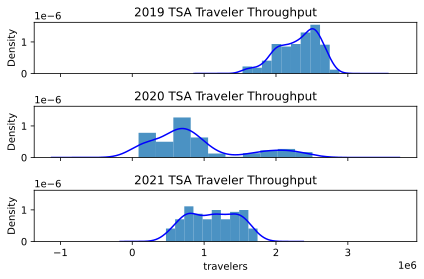

In [ ]:
# define the subplot layout
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(6, 4))

for year, ax in zip(tsa_melted_holiday_travel.year.unique(), axes):
    plot_data = tsa_melted_holiday_travel.loc[str(year)].travelers
    plot_data.plot(kind='hist', legend=False, density=True, alpha=0.8, ax=ax)
    plot_data.plot(kind='kde', legend=False, color='blue', ax=ax)
    ax.set(title=f'{year} TSA Traveler Throughput', xlabel='travelers')

fig.tight_layout() # handle overlaps

*Dica: Se você é não conhecia a função `zip()`, olhe [este](https://realpython.com/python-zip-function/) artigo.*

## Plotando com o Seaborn

A biblioteca Seaborn providencia os meios para facilmente visualizar dados com formato longo sem pivotear primeiro. Além disso, também oferece tipos adicionais de plotagem &ndash; mais uma vez construindo por cima do Matplotlib. Aqui, vamos olhar para alguns exemplos de visualizações que podemos criar com Seaborn.

### Visualizando dados de formato longo

Com o Seaborn, nós podemos especificar cores de plotagem de acordo com os valores de uma coluna com o parâmetro `hue`. Quando trabalhando com funções que gerem subplots, podemos também especificar como dividir os subplots por valores de uma coluna de formato longo, com os parâmetros `col` e `row`. Aqui, vamos revisitar a comparação de distribuição do fluxo de passageiros TSA ao longo dos anos:

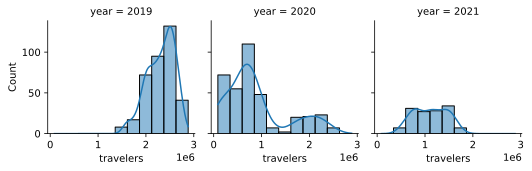

In [ ]:
import seaborn as sns

sns.displot(
    data=tsa_melted_holiday_travel, x='travelers', col='year', kde=True, height=2.5
)

### Mapas de calor
Nós também podemos usar as tabelas de pivôs como mapas de calor:

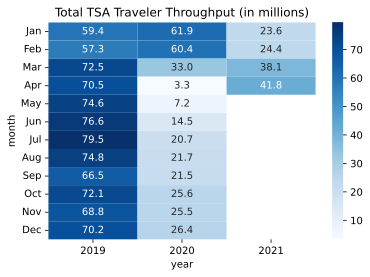

In [ ]:
data = tsa_melted_holiday_travel['2019':'2021-04']\
    .assign(month=lambda x: x.index.month)\
    .pivot_table(index='month', columns='year', values='travelers', aggfunc='sum')

ax = sns.heatmap(data=data / 1e6, cmap='Blues', annot=True, fmt='.1f')
_ = ax.set_yticklabels(calendar.month_abbr[1:], rotation=0)
_ = ax.set_title('Total TSA Traveler Throughput (in millions)')

*Dica: Olhe a documentação do Matplotlib para mais informação em [colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html) e [cores nomeadas](https://matplotlib.org/stable/gallery/color/named_colors.html).*

Estamos saindo do Seaborn por agora, mas tem muito mais disponível na [API](https://seaborn.pydata.org/api.html). Lembre de checar, pelo menos, os seguintes:
- [pairwise plots](https://seaborn.pydata.org/generated/seaborn.pairplot.html#seaborn.pairplot) com o `pairplot()`
- [Gráficos de disperção categóricos](https://seaborn.pydata.org/generated/seaborn.swarmplot.html#seaborn.swarmplot) com o `swarmplot()`
- [Plotagens de distribuição conjuntas](https://seaborn.pydata.org/generated/seaborn.jointplot.html#seaborn.jointplot) com o ``jointplot()`
- [FacetGrids](https://seaborn.pydata.org/generated/seaborn.FacetGrid.html#seaborn.FacetGrid) para layouts customizados com qualquer tipo de plotagem

## Customizando plotagens com o Matplotlib

Nesta seção final, vamos discutir como usar o Matplotlib para customizar plotagens. Como tem muitas funcionalidades disponíveis, vamos apenas cobrir como adicionar regiões regiões sombreadas e anotações, mas dê uma olhadinha na [documentação](https://matplotlib.org/) para obter mais informações.

### Adicionando regiões sombreadas

Quando olhando para a plotagem do fluxo de passageiros TSA ao longo do tempo, é útil indicar períodos durante os quais houveram uma viagem de férias. Podemos fazer isso com o método `avxspan()`:

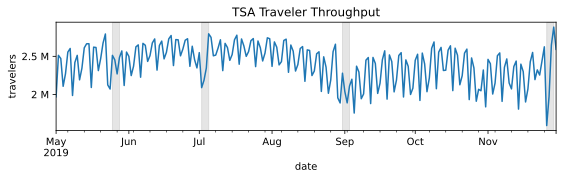

In [ ]:
plot_data = tsa_melted_holiday_travel['2019-05':'2019-11']
ax = plot_data.travelers.plot(
    title='TSA Traveler Throughput', ylabel='travelers', figsize=(9, 2)
)
ax.yaxis.set_major_formatter(ticker.EngFormatter())

# collect the holiday ranges (start and end dates)
holiday_ranges = plot_data.dropna().reset_index()\
    .groupby('holiday').agg({'date': ['min', 'max']})

# create shaded regions for each holiday in the plot
for start_date, end_date in holiday_ranges.to_numpy():
    ax.axvspan(start_date, end_date, color='gray', alpha=0.2)

*Dica: Use `axhspan` para regiões horizontalmente sombreadas e `axvline` / `axhline()` para linhas verticais/horizontais de referência.*

### Adicionando anotações

Nós podemos usar o método `annotate()` para adicionar anotações para a plotagem. Aqui, nós pontuamos o dia em 2019 com o maior fluxo de passageiros TSA, que foi no dia depois do dia de ação de graças:

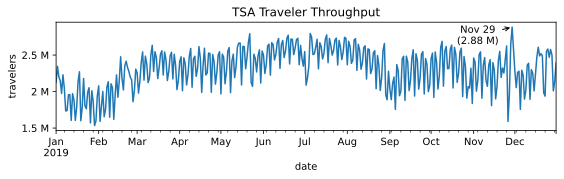

In [ ]:
plot_data = tsa_melted_holiday_travel.loc['2019']
ax = plot_data.travelers.plot(
    title='TSA Traveler Throughput', ylabel='travelers', figsize=(9, 2)
)
ax.yaxis.set_major_formatter(ticker.EngFormatter())

# highest throughput
max_throughput_date = plot_data.travelers.idxmax()
max_throughput = plot_data.travelers.max()
_ = ax.annotate(
    f'{max_throughput_date:%b %d}\n({max_throughput / 1e6:.2f} M)',
    xy=(max_throughput_date, max_throughput),
    xytext=(max_throughput_date - pd.Timedelta(days=25), max_throughput * 0.92),
    arrowprops={'arrowstyle': '->'}, ha='center'
)

Algumas coisas para manter em mente:
- Nós usamos os métodos `Axes` para customizar nossa plotagem (isto é, uma abordagem orientada à objetos), mas o módulo `pyplot` providencia funções equivalentes (isto é, uma abordagem funcional) para adicionar regiões sombreadas, linhas de referência, anotações, etc. &ndash; ainda que os nomes das funções possam ser significativamente diferentes dos seus métodos de contrapartida `Axes` (exemplo, `Axes.set_xlabel()` vs `plt.xlabel()`).
- Em geral, tente escolher um dos dois, a abordagem orientada à objetos ou a abordagem funcional, em vez de misturar os dois. No entanto, seja cuidado quando trabalhando com subplotagens &ndash; funções `pyplot` vão apenas afetar a última subplotagem.
- O diagrama de [anatomia de uma figura](https://matplotlib.org/stable/gallery/showcase/anatomy.html) na documentação Matplotlib é um ótimo recurso para identificar quais objetos você vai precisar para acessar as customizações de plotagem.



Para mais visualização de dados em Python, incluindo animações e plotagens interativas, cheque o meu workshop [Beyond the Basics: Data Visualization in Python](https://github.com/stefmolin/python-data-viz-workshop).

## Vindo aí: Laboratório de análise mão-na-massa de dados

Vamos agora dar uma pausa para fazer alguns exercícios e checar seu aprendizado:

1. Crie plotagens de caixa para o fluxo de passageiros TSA para cada ano nos dados. Dica: Passe `kind='box'` para o método `plot()` para gerar plotagens de caixa.
2. Usando Seaborn, crie um heatmap para mostrar a média de fluxo de passageiros TSA em 2019, pelo dia da semana e mês. Dica: Faça uma tabela de pivôs primeiro.
3. Anote as médias em uma plotagem de caixa do *#1*. Dica: As coordenadas `x` serão 1, 2, e 3 para 2019, 2020 e 2021, respectivamente. Alternativamente, para evitar dar hardcode nos valores, você pode usar o método `Axes.get_xticklabels()`, no qual você deve olhar a [documentação](https://matplotlib.org/stable/api/text_api.html) para a classe `Text`.

### Exercícios

#####1. Crie plotagens de caixa para o fluxo de passageiros TSA para cada ano nos dados. Dica: Passe `kind='box'` para o método `plot()` para gerar plotagens de caixa.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


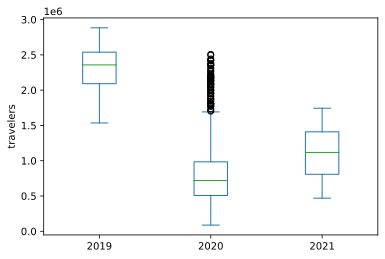

In [ ]:
# Faço um pivoteamento dos valores de fluxo por ano
pivot_tsa = tsa_melted_holiday_travel.pivot(
    columns='year', 
    values='travelers'
)

# Boxplot do pivoteamento acima
plot_tsa = pivot_tsa.plot(
    kind='box', ylabel='travelers'
)

##### 2. Usando Seaborn, crie um heatmap para mostrar a mediana de fluxo de passageiros TSA em 2019, pelo dia da semana e mês. Dica: Faça uma tabela de pivôs primeiro.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  # This is added back by InteractiveShellApp.init_path()


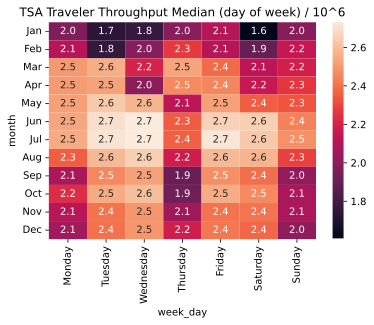

In [ ]:
import seaborn as sns

# Utilizo esse dic apenas para ordenar os meses de forma correta pela ordem do ano e
# a ordem semanal
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Pego apenas as viagens de 2019 e adiciono as colunas de mês e dia da semana
data = tsa_melted_holiday_travel['2019'].assign(month=lambda x: x.index.strftime('%b'), week_day=lambda x: x.index.strftime('%A'))

# Ordenação por ordem anual
data['month'] = pd.CategoricalIndex(data['month'], categories=months, ordered=True)
data = data.sort_values('month')

# Ordenação da ordem semanal dos dias da semana
data['week_day'] = pd.CategoricalIndex(data['week_day'], categories=days, ordered=True)
data = data.sort_values('week_day')

# Crio a tabela pivotada com as medianas
pivot_data = data.pivot_table(index='month', columns='week_day', values='travelers', aggfunc='median')

# Plot do heatmap (divido por 1e6 para ficar melhor de vizualizar os valores)
heatmap_data = sns.heatmap(pivot_data/ 1e6, annot=True, fmt='.1f')
_ = heatmap_data.set_title('TSA Traveler Throughput Median (day of week) / 10^6')

##### 3. Anote as medianas na plotagem de caixa do *#1*. Dica: As coordenadas `x` serão 1, 2, e 3 para 2019, 2020 e 2021, respectivamente. Alternativamente, para evitar dar hardcode nos valores, você pode usar o método `Axes.get_xticklabels()`, no qual você deve olhar a [documentação](https://matplotlib.org/stable/api/text_api.html) para a classe `Text`.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


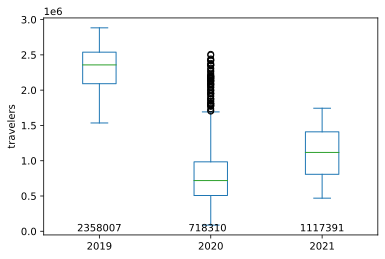

In [ ]:
# Plot do exercício 1:
pivot_tsa = tsa_melted_holiday_travel.pivot(
    columns='year', 
    values='travelers'
)

plot_tsa = pivot_tsa.plot(
    kind='box', ylabel='travelers'
)

# Anotação das medianas no gráfico:

# Acho as medianas e converto os valores para uma lista
pivot_medians = tsa_melted_holiday_travel.pivot_table(
    columns='year', 
    values='travelers', aggfunc='median'
).T
medians = pivot_medians.travelers.tolist()

# Escrevo os valores das medians no plot utilizando as coordenadas dos tick labels
labels = plot_tsa.get_xticklabels()
for i in range(len(medians)):
  coords = labels[i].get_position()
  plot_tsa.text(i+0.8, coords[1], str(int(medians[i])))
